<a href="https://colab.research.google.com/github/Justinezgh/SBI-Diff-Simulator/blob/u%2FJustinezgh%2Fapt/SBI-Diff-Simulator/notebooks/dev/APT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet jax-cosmo numpyro dm-haiku==0.0.5 optax
!pip install --quiet git+https://github.com/Justinezgh/SBI-Diff-Simulator.git

     |████████████████████████████████| 283 kB 27.3 MB/s 
     |████████████████████████████████| 291 kB 57.3 MB/s 
     |████████████████████████████████| 287 kB 57.5 MB/s 
     |████████████████████████████████| 145 kB 63.7 MB/s 
     |████████████████████████████████| 76 kB 5.3 MB/s 
     |████████████████████████████████| 128 kB 33.3 MB/s 


In [ ]:
!pip install matplotlib==3.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import logging
# Removing annoying TFP error message
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import os
import argparse
import pickle
from functools import partial

import optax
import haiku as hk
import numpy as np
import jax
import jax.numpy as jnp
from numpyro.handlers import condition

import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions


from sbids.metrics.c2st import c2st
from sbids.tasks import (
  lotka_volterra, lotka_volterra_y_bijector, 
  lotka_volterra_theta_bijector, get_samples_and_scores
)
from sbids.models import AffineSigmoidCoupling, ConditionalRealNVP

In [ ]:
# create model compressor 
class Compressor(hk.Module):

  def __call__(self, x):
    
    x = x/1000
    x = x[..., jnp.newaxis]

    net_x = hk.Conv1D(32, 3, 1)(x) 
    net_x = jax.nn.leaky_relu(net_x) 
    net_x = hk.Conv1D(64, 4, 2)(net_x) 
    net_x = jax.nn.leaky_relu(net_x) 
    net_x = hk.Conv1D(128, 3, 1)(net_x)
    net_x = jax.nn.leaky_relu(net_x) 
    net_x = hk.Flatten()(net_x) 
    
    net_x = hk.Linear(32)(net_x) 
    net_x = jax.nn.leaky_relu(net_x) 
    net_x = hk.Linear(16)(net_x) 
    net_x = jax.nn.leaky_relu(net_x) 
    net_x = hk.Linear(4)(net_x) 

    return net_x.squeeze()

bijector_layers_compressor = [128] * 2

bijector_compressor = partial(
  AffineSigmoidCoupling, 
  layers=bijector_layers_compressor, 
  n_components=16, 
  activation=jax.nn.silu
)

NF_compressor = partial(
  ConditionalRealNVP, 
  n_layers=3, 
  bijector_fn=bijector_compressor)


class Flow_nd_Compressor(hk.Module):
    def __call__(self, y):
        nvp = NF_compressor(4)(y)
        return tfd.TransformedDistribution(nvp,
                                           tfb.Chain([tfb.Invert(lotka_volterra_theta_bijector),
                                                      tfb.Scale(30.),
                                                      tfb.Shift(-0.5)]))

# compressor
compressor = hk.without_apply_rng(hk.transform(lambda x : Compressor()(x)))
# nf
nf = hk.without_apply_rng(hk.transform(lambda p,x : Flow_nd_Compressor()(x).log_prob(p).squeeze()))

a_file = open("/content/params_compressor4.pkl", "rb")
parameters_compressor = pickle.load(a_file)

# reg = compressor.apply(parameters_compressor,batch)
scale_reg = jnp.array([ 6.233213, 13.966835, 13.656771,  7.450791]) #(jnp.std(reg, axis =0)/0.04)
shift_reg = jnp.array([-0.4551523,  -0.48648357, -0.50399256, -0.4354317 ])#jnp.mean(reg/scale_reg, axis = 0)-0.5

In [ ]:
# create nf model 
from functools import partial
bijector_layers = [128] * 2

bijector_npe = partial(
  AffineSigmoidCoupling, 
  layers=bijector_layers, 
  n_components=16, 
  activation=jax.nn.silu
)

NF_npe = partial(
  ConditionalRealNVP, 
  n_layers=4, 
  bijector_fn=bijector_npe)


class SmoothNPE(hk.Module):
    def __call__(self, y):
        net = y/scale_reg - shift_reg
        nvp = NF_npe(4)(net)
        return tfd.TransformedDistribution(nvp,
                                           tfb.Chain([tfb.Invert(lotka_volterra_theta_bijector),
                                                      tfb.Scale(30.),
                                                      tfb.Shift(-0.5)]))
        
nvp_nd_logprob = hk.without_apply_rng(hk.transform(lambda theta,y : SmoothNPE()(y).log_prob(theta).squeeze()))
nvp_nd_prob = hk.without_apply_rng(hk.transform(lambda theta,y : SmoothNPE()(y).prob(theta).squeeze()))

In [ ]:
# Create obs x0
seed_for_truth = 0
model = lotka_volterra
(log_probs, samples), scores = get_samples_and_scores(model, jax.random.PRNGKey(seed_for_truth), batch_size=1)
truth, observation = samples['theta'], samples['y'].reshape([-1,20],order='F')

obs = compressor.apply(parameters_compressor, observation.reshape([1,20]))

In [ ]:
batch_size=256
n_simulations=1000#0
n_steps=20
score_weight=0#1e-7
model_seed=0
initial_learning_rate=0.002


rng_seq = hk.PRNGSequence(model_seed)

R = 1
N = n_simulations
n = int(N/R) 
M = 10

In [ ]:
  def data_stream(key, c, batch, mu, score):
    """
    Creates a data stream with a predefined batch size.
    """
    rng = np.random.RandomState(key)
    while True:
      perm = rng.permutation(c)
      for i in range(c // M):
        batch_idx = perm[i * M: (i + 1)*M]
        yield batch[batch_idx], mu[batch_idx], score[batch_idx]



  def loss_fn(params, weight, mu, batch, score):

    prior = tfd.LogNormal(loc=jnp.array([-0.125,-3,-0.125,-3]),
                          scale=jnp.array([0.5, 0.5, 0.5, 0.5]))
    
    y = compressor.apply(parameters_compressor, batch)

    _, out = jax.vmap( 
      jax.value_and_grad(lambda theta, x: nvp_nd_logprob.apply(params, theta.reshape([1,4]), x.reshape([1,4])).squeeze())
      )(mu, y)
    
    repeat_y = jnp.repeat(y, M, axis = 0)
    repeat_mu = jnp.concatenate([mu] * M, axis=0)
    prob, _ = jax.vmap( 
      jax.value_and_grad(lambda theta, x: nvp_nd_prob.apply(params, theta.reshape([1,4]), x.reshape([1,4])).squeeze())
      )(repeat_mu, repeat_y)

    prior_prob = prior.prob(mu).prod(axis = 1)
    sum = jnp.sum(prob.reshape(M,-1)/prior_prob, axis = 1)
    prob_diag = prob.reshape(M,-1).diagonal()

    # return -jnp.mean(jnp.log((prob_diag/prior_prob)/sum)) #+ weight * jnp.mean(jnp.sum((out - score)**2, axis=1)) 
    # return -jnp.mean(jnp.log(prob_diag/(prior_prob*sum))) #+ weight * jnp.mean(jnp.sum((out - score)**2, axis=1)) 
    return -jnp.mean(jnp.log(prob_diag) - jnp.log(prior_prob) - jnp.log(sum))


  @jax.jit
  def update(params, opt_state, weight, mu, batch,score):
      """Single SGD update step."""

      loss, grads = jax.value_and_grad(loss_fn)(params, weight, mu, batch,score)
      updates, new_opt_state = optimizer.update(grads, opt_state, params)
      new_params = optax.apply_updates(params, updates)
    
      return loss, new_params, new_opt_state

In [ ]:
from tqdm import tqdm

100%|██████████| 100/100 [00:01<00:00, 58.48it/s]


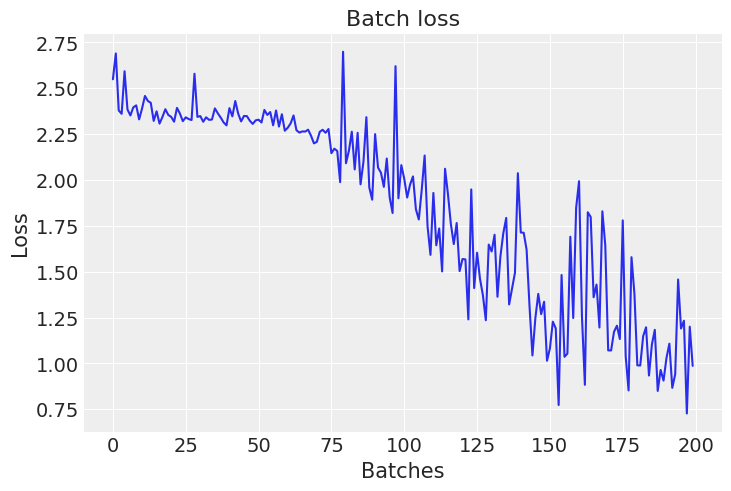

In [ ]:
# APT algo


batch_loss = []
MU = []
BATCH = []
SCORE = []
c = 0

# init parameters
params_nd = nvp_nd_logprob.init(next(rng_seq),  0.5*jnp.ones([1,4]), 0.5*jnp.ones([1,4]))

# init optimizer
scheduler = optax.exponential_decay(init_value=0.001, transition_steps=1000, decay_rate=0.9, end_value=0.00001)
optimizer = optax.chain(#optax.adaptive_grad_clip(0.01, eps=0.001),
                        optax.scale_by_adam(), 
                        optax.scale_by_schedule(scheduler), 
                        optax.scale(-1))
opt_state = optimizer.init(params_nd)


# APT
for r in range(R): 
  if r == 0: 
    thetas = None
  else: 
    nvp_sample_nd = hk.transform(lambda x : SmoothNPE()(x).sample(n, seed=hk.next_rng_key()))
    sample_nd = nvp_sample_nd.apply(params_nd, 
                                    rng = next(rng_seq), 
                                    x = obs*jnp.ones([n,4]))

  @jax.jit
  def get_batch(key, batch_size = n):
      model = lotka_volterra
      (log_probs, samples), scores = get_samples_and_scores(model, key, batch_size=batch_size, thetas=thetas)
      return samples['theta'], samples['y'].reshape([-1,20], order='F'), scores

  mu, batch, score = get_batch(jax.random.PRNGKey(62))

  MU.append(mu)
  BATCH.append(batch)
  SCORE.append(score)
  c += n

  if jnp.isnan(score).any() == True:
    idx = jnp.where(jnp.isnan(score))[0]
    batch = jnp.delete(batch, idx, axis=0)
    mu = jnp.delete(mu, idx, axis=0)
    score = jnp.delete(score, idx, axis=0)

  # train nf
  for epoch in range(2):
    batch_generator = data_stream(c+epoch, c, jnp.array(BATCH)[0], jnp.array(MU)[0], jnp.array(SCORE)[0])
    for batch in tqdm(range(c // M)):
        b,m,s = next(batch_generator)
        l, params_nd2, opt_state = update(params_nd, opt_state, score_weight, m, b, s)
        if jnp.isnan(l):
          break
        params_nd = params_nd2
        batch_loss.append(l)
    if jnp.isnan(l):
      break


  import arviz as az
  import matplotlib.pyplot as plt
  az.style.use("arviz-darkgrid")
  
  plt.clf()
  plt.plot(batch_loss)
  plt.title("Batch loss")
  plt.xlabel("Batches")
  plt.ylabel("Loss")
  plt.savefig('/content/loss%d.png' %r)

In [ ]:
# try to find the nans 
batch_generator = data_stream(c+epoch, c, jnp.array(BATCH)[0], jnp.array(MU)[0], jnp.array(SCORE)[0])

In [ ]:
b,m,s = next(batch_generator)

In [ ]:
loss, grads = jax.value_and_grad(loss_fn)(params_nd, 0, m, b,s)

In [ ]:
loss

DeviceArray(0.927447, dtype=float32)

In [ ]:
grads

FlatMap({
  'smooth_npe/conditional_real_nvp/b0/l3': FlatMap({
                                             'b': DeviceArray([-1.15886405e-02, -3.27864895e-03, -1.81777239e-01,
                                                               -4.31307144e-02, -1.81914344e-02, -1.51367694e-01,
                                                               -8.49612150e-03,  3.55253331e-02,  1.83460824e-02,
                                                                4.61368822e-02,  1.24866620e-03,  3.82853411e-02,
                                                                3.14293861e-01, -4.75707930e-05, -2.88718170e-03,
                                                                4.81653124e-01,  1.02972984e-03, -4.11020452e-03,
                                                               -2.69063599e-02, -8.93997401e-02, -1.60861492e-01,
                                                               -8.20495375e-03,  1.42473578e-01, -3.97406667e-02,
                         

In [ ]:
l, params_nd2, opt_state = update(params_nd, opt_state, score_weight, m, b, s)

In [ ]:
l

DeviceArray(0.92744476, dtype=float32)

In [ ]:
params_nd2

FlatMap({
  'smooth_npe/conditional_real_nvp/b0/l3': FlatMap({
                                             'b': DeviceArray([-0.0062558 ,  0.002228  ,  0.00682316, -0.00248394,
                                                               -0.02147837, -0.00785576, -0.01082713, -0.01380973,
                                                               -0.01768722, -0.00772823, -0.00977801, -0.00933954,
                                                               -0.00102811, -0.00868089, -0.00924199, -0.00079216,
                                                               -0.00546086, -0.01083217, -0.01951507,  0.02236736,
                                                                0.01107532, -0.00756372, -0.01159896,  0.0233402 ,
                                                               -0.011498  , -0.0003503 , -0.00947019, -0.00714982,
                                                               -0.00561514, -0.01041616, -0.00839762,  0.00093604],            dtype

In [ ]:
# evaluate model
nvp_sample_nd = hk.transform(lambda x : SmoothNPE()(x).sample(10000, seed=hk.next_rng_key()))
rng_seq = hk.PRNGSequence(19)
for seed_for_truth in range(1):
    # create truth
    model = lotka_volterra
    (log_probs, samples), scores = get_samples_and_scores(model, jax.random.PRNGKey(seed_for_truth), batch_size=1)
    truth, observation = samples['theta'], samples['y'].reshape([-1,20],order='F')
    reference_samples = jnp.load('reference_sample_seed%d.npy' % seed_for_truth)

    y = compressor.apply(parameters_compressor, observation.reshape([1,20]))
    sample_nd = nvp_sample_nd.apply(params_nd2, 
                                    rng = next(rng_seq), 
                                    x = obs*jnp.ones([10000,4]))

/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/pairplot.py:98: UserWarning: Argument reference_values does not include reference value for: delta, gamma, beta
  UserWarning,
/usr/local/lib/python3.7/dist-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


ValueError: ignored

<Figure size 1000x1000 with 0 Axes>

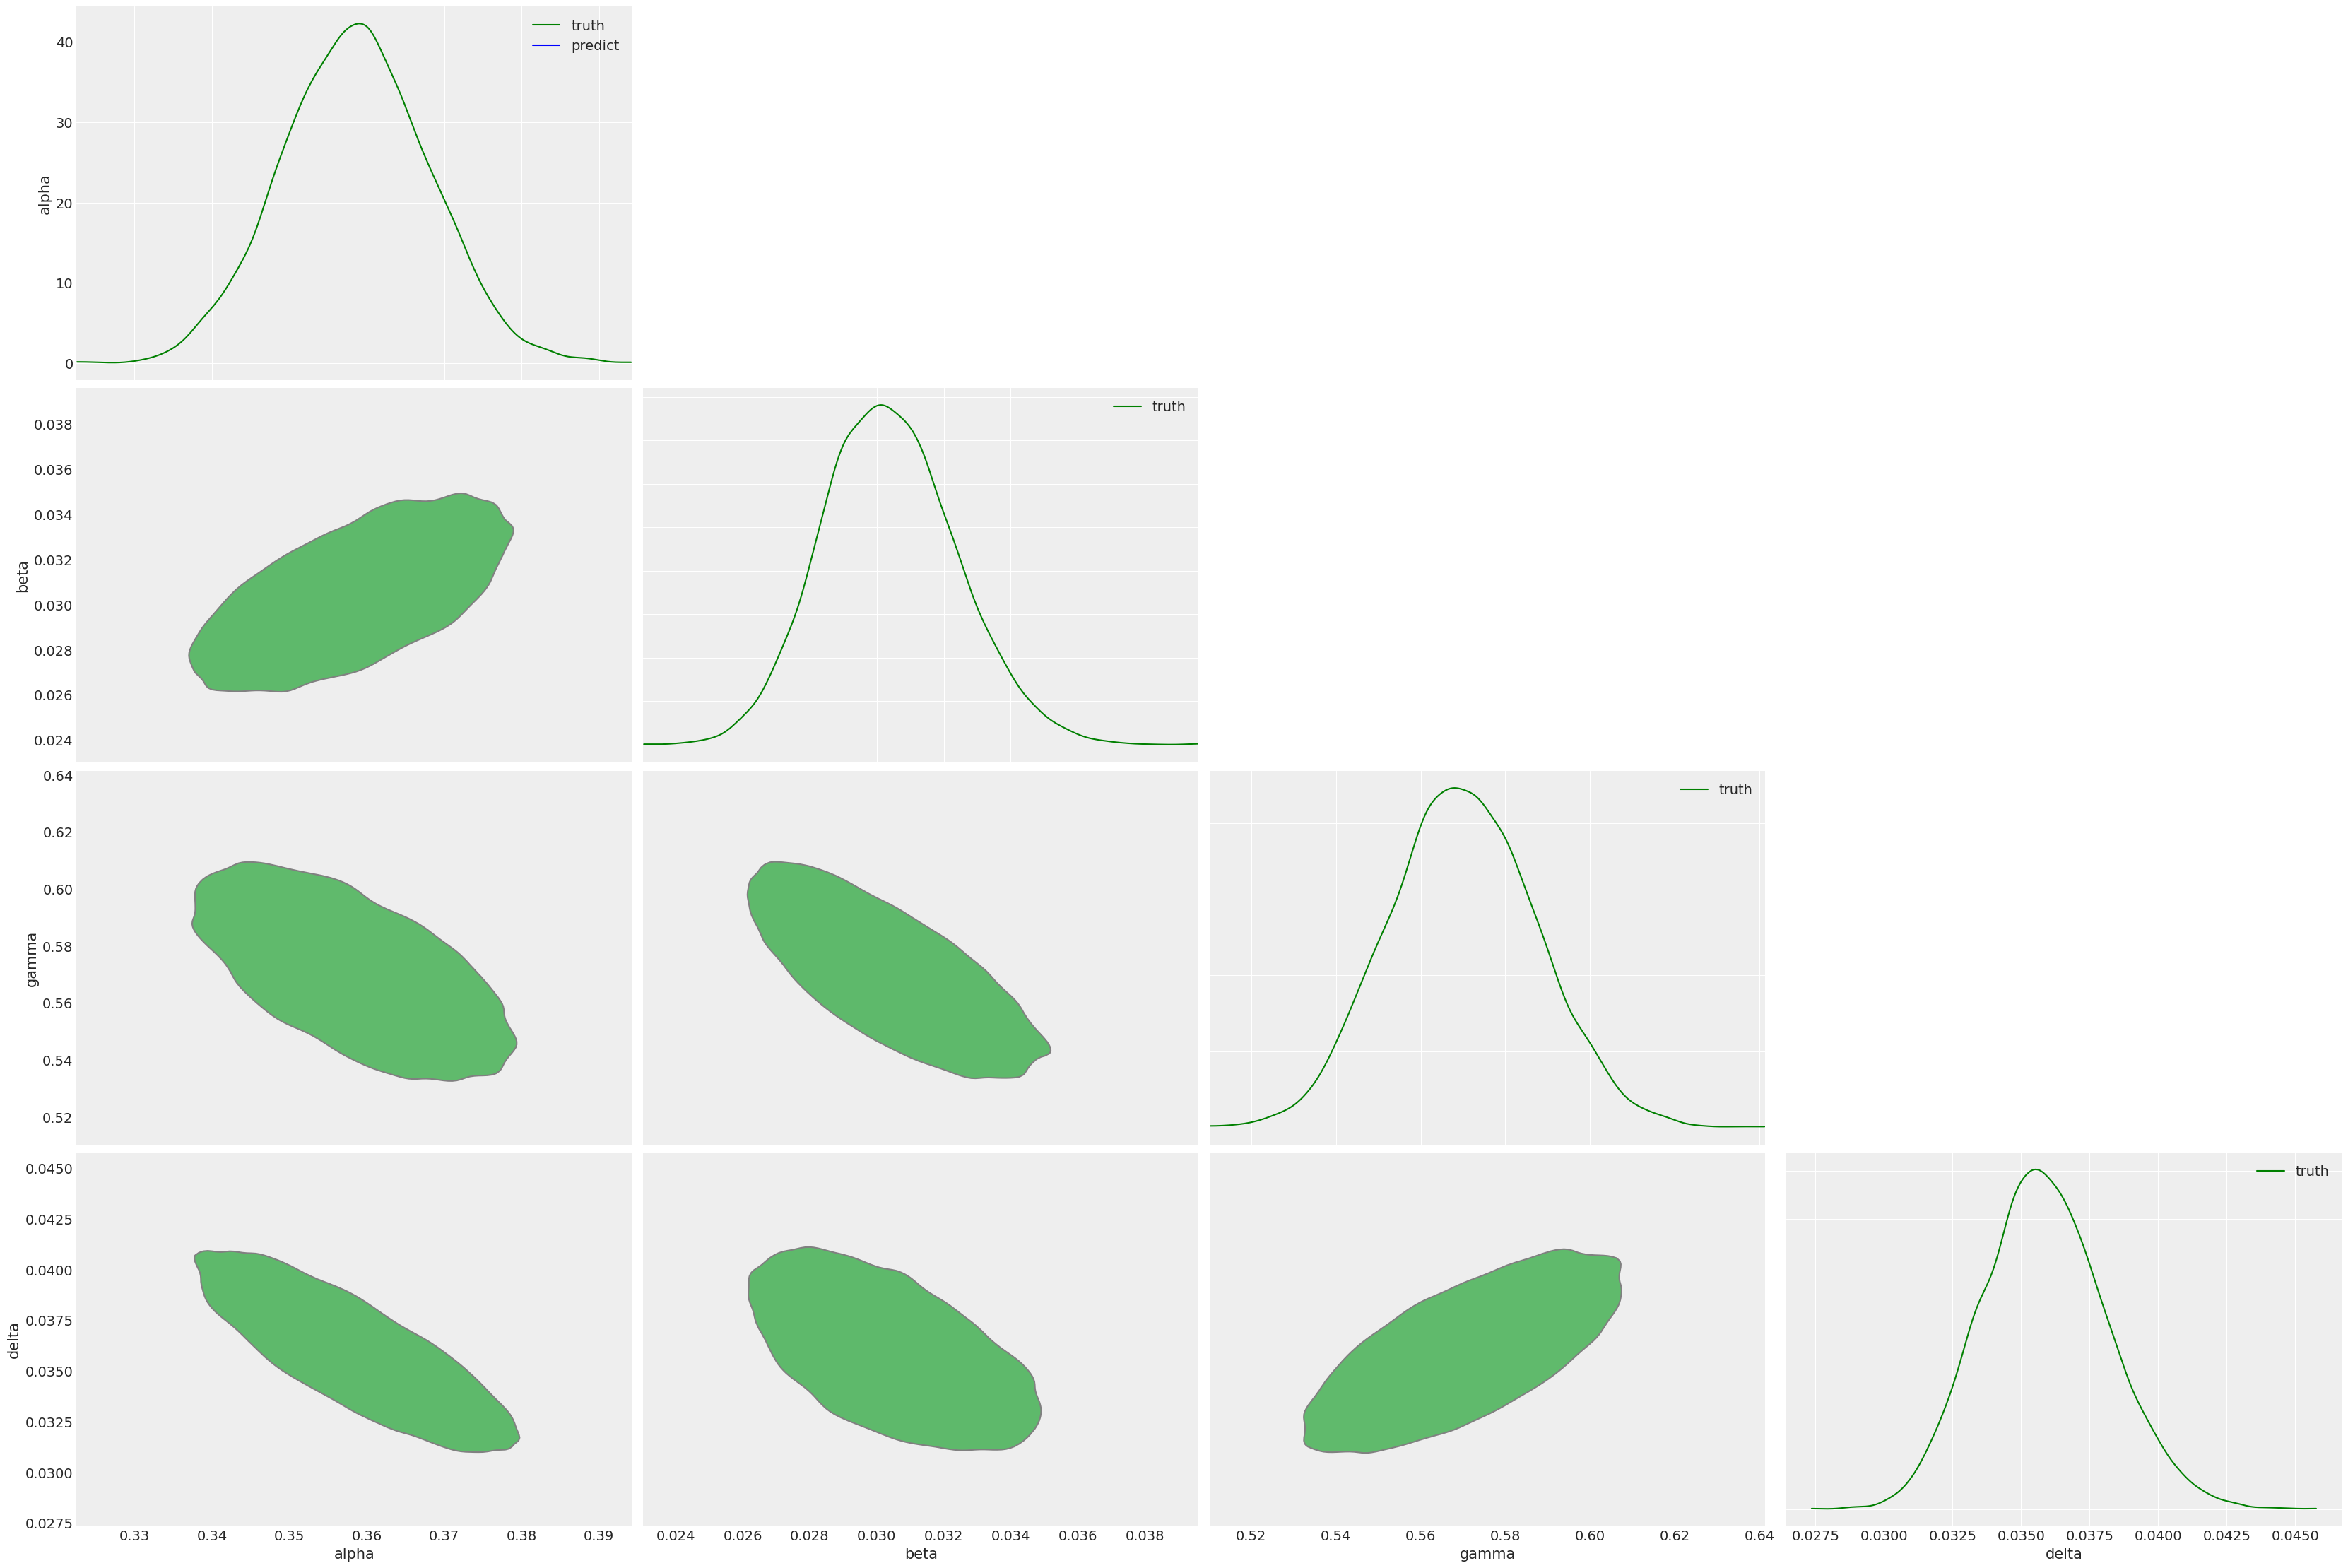

In [ ]:
  import arviz as az
  az.style.use("arviz-darkgrid")

  parameters = ["alpha", "beta", "gamma", "delta"]

  plt.figure(figsize=(10, 10))
  ax = az.plot_pair(
      data={
        k: reference_samples[:,i]
        for i,k in enumerate(parameters)
      },
      kind="kde",
      var_names=parameters,
      kde_kwargs={
          "hdi_probs": [0.9],  # Plot 30%, 60% and 90% HDI contours
          "contourf_kwargs": {"cmap": "Greens"},
      },
      marginals=True,
      marginal_kwargs={'color': 'g', 'label': 'truth'},

  )
  az.plot_pair(
      data={
        k: sample_nd[:,i] 
        for i,k in enumerate(parameters)
      },
      kind="kde",
      var_names=parameters,
      kde_kwargs={
          "hdi_probs": [0.9],  # Plot 30%, 60% and 90% HDI contours
          "contourf_kwargs": {"cmap": "Blues", "alpha": 0.7},
      },
      marginals=True,
      marginal_kwargs={'color': 'b', 'label': 'predict'}, 
      reference_values=dict(zip(parameters, np.array(truth))),
      reference_values_kwargs={'markersize': 10, 'color': 'r', 'label': 'truth'}, 
      ax=ax
  )

In [ ]:
# params_nd = params_nd2
batch_loss.append(l)

In [ ]:
params_nd = params_nd2

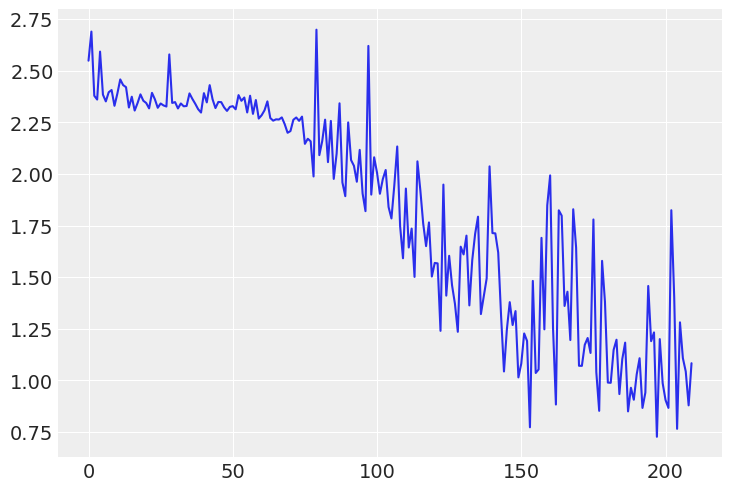

In [ ]:
plt.plot(batch_loss)